<a href="https://colab.research.google.com/github/Develtomas/Python_course/blob/main/task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Решение
Как в итоге было сделано:

*   развернул на google cloud platform инстансе с ubuntu
*   на инстансе запустил 2 докер контейнера с postgresql
*   на них развернул оперативную и базу хранилища
*   в среде collab запустил airflow 2.5.1
*   заполнял оперативную DB, запускал ETL и заполнял базы DWH
*   в Power BI подтянул пакетом данные из dwh. Создал дэшборд.
  
подробнее далее ->

##### 1 пункт
Так как персональный лаптоп у меня слабый разворачиваю DB на Google Cloud Platform.

*   создаю инстанс, с виртуальной машиной  Ubuntu 20.04.5 LTS
*   ставлю Docker engine
*   качаю образ postgres latest
*   создаем два контейнера operate и dwh (инстанс под оперативную и под dwh)

```
docker run --name operate -e POSTGRES_PASSWORD=postgres -p 5432:5432 -v /home/develtomas/operate:/var/lib/postgresql/data -d postgres

docker run --name dwh -e POSTGRES_PASSWORD=postgres -p 5400:5432 -v /home/develtomas/dwh:/var/lib/postgresql/data -d postgres
```

*   в контейнерах создаем базы данных через psql
    * на контейнере operate -> оперативная DB
    * на контейнере dwh -> mrr, stg, dwh
*   коннект через dbeaver

*   cоздаем таблицы в оперативной базе. Дополнительно создаем view, для получение watermark в оперативной базе. Тут я добавил id в таблицу sales, без него неудобно считать дельты по watermark.

```
create table customers (
	id int generated always as identity primary key,
	"name" varchar not null,
	country varchar not null
);
create table products (
	id int generated always as identity primary key,
	"name" varchar not null,
	groupname varchar not null
);
create table sales (
	id int generated always as identity primary key,
	customerId int references customers(id), 
	productId int references products(id), 
	qty int not null
);
create or replace view watermark as
select
	to_char(CURRENT_DATE, 'yyyymmdd')::int as "date_key",
	COALESCE((select id from sales order by id desc limit 1), 0) as last_sale,
	coalesce((select id from products order by id desc limit 1), 0) as last_product,
	coalesce ((select id from customers order by id desc limit 1), 0) as last_customer;
	
--select to_char(current_date,'yyyymmdd')::int;
--drop view watermark;
```


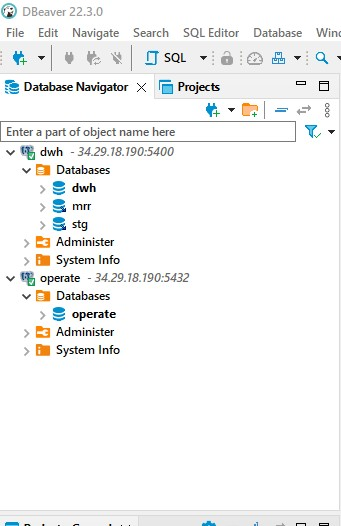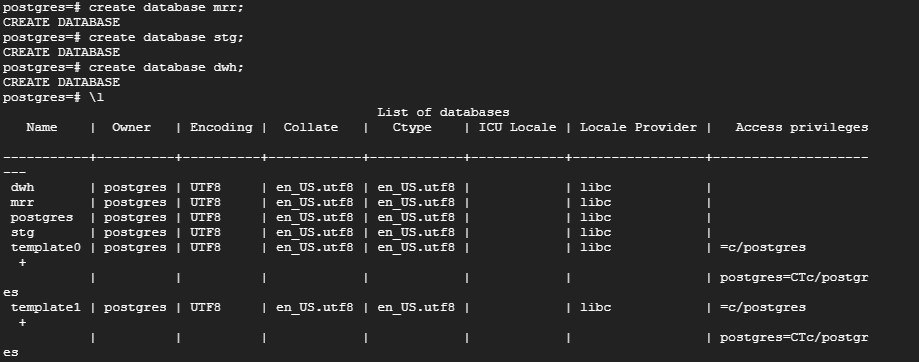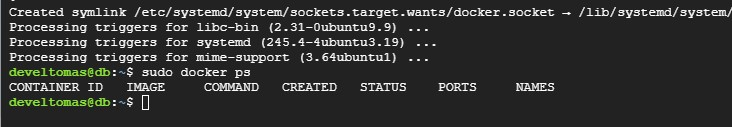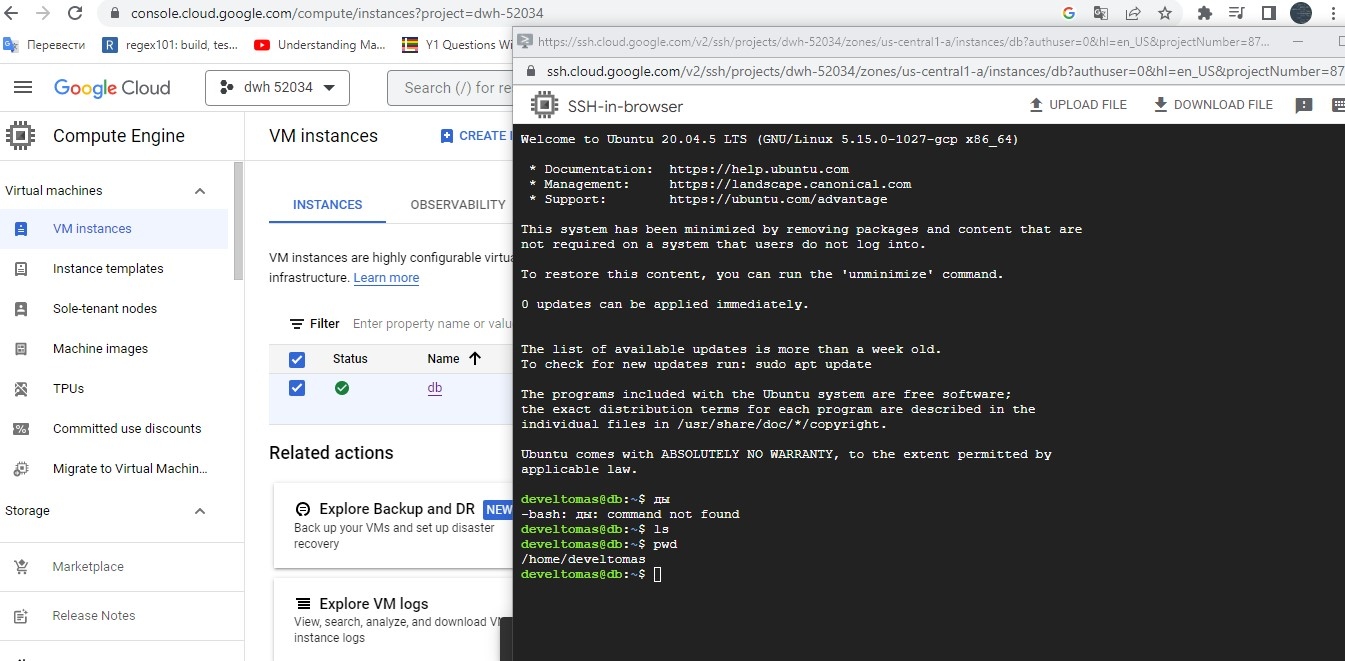

##### Пункт 2
***!!! так как в условиях ничего не сказано о SCD их не реализую. Изменения в клиенте, продукте, etc., предполагаются как добавление нового продукта, клиента в таблицы измеренией.***

Для чего 3 базы -
*   mrr - не нашел этого определиния , но суть понятная - это ODS, копия оперативной базы, для работы "напрямую". Основная цель не нагружать транзакционную базу ненужными запросами.

*   stg - стейджинг временаая база перед заливкой на dwh, содержит краткосроыне данные ( за прошлую выгрузку, за неделю , за месяц) , сюда же подтягивают информацию из сторонних источников для интеграции.

*   dwh - непосредственно хранилище, с ним уже работа идет через BI инструменты или еще какие-либо внешние сервисы.

Реализация

*   mrr база аналогична оперативной базе. Внешние ключи в этой базе сохранены. Единственно, что добавлю - это столбец date_key в таблицу mrr_fact_sales (чтобы потом в dwh добавить dimension date). Так же содержит view c mrr_watermark, для нахождения дельты при выгрузке.

```
create table mrr_dim_customers (
	id int primary key,
	"name" varchar not null,
	country varchar not null
);
create table mrr_dim_products (
	id int primary key,
	"name" varchar not null,
	groupname varchar not null
);
create table mrr_fact_sales (
	id int primary key,
	customerId int references mrr_dim_customers(id), 
	productId int references mrr_dim_products(id), 
	qty int not null,
	date_key int not null
);
create or replace view mrr_watermark as
select
	COALESCE((select date_key from mrr_fact_sales order by date_key desc limit 1), 0) as last_date_key,
	COALESCE((select id from mrr_fact_sales order by id desc limit 1), 0) as last_sale,
	coalesce((select id from mrr_dim_products order by id desc limit 1), 0) as last_product,
	coalesce ((select id from mrr_dim_customers order by id desc limit 1), 0) as last_customer;
	
--select to_char(current_date,'yyyymmdd')::int;
--select * from mrr_watermark;
```

*   stg так как интегрировать ничего не надо, историчность тоже не требуется. Убираем ключи. Сюда буду загружать напрямую во время выгрузки из оперативной в mrr, чтобы не держать в этой базе watermark. После загрузки в dwh таблицы базы будут очищаться.

```
create table stg_dim_customers (
	id int not null,
	"name" varchar default 'no name',
	country varchar default 'no name'
);
create table stg_dim_products (
	id int not null,
	"name" varchar default 'no name',
	groupname varchar default 'no name'
);
create table stg_fact_sales (
	id int not null,
	customerId int not null, 
	productId int not null,
	qty int default 0,
	date_key int not null
);

--drop table stg_dim_customers;
```

*   dwh дополительно добавлю таблицу dwh_dim_date. Она будет заполнена позже посредством процедуры, нужна для срезов по времени при построении отчетов.

```
create table dwh_dim_customers (
	id int not null default 0,
	"name" varchar not null default 'no name',
	country varchar not null default 'no name'
);
create table dwh_dim_products (
	id int not null default 0,
	"name" varchar not null default 'no name',
	groupname varchar not null default 'no name'
);
create table dwh_dim_dates (
	date_key int not null generated by default as identity,
	"date" date not null,
	"day" int not null,
	"month" int not null,
	"year" int not null 
);
create table dwh_fact_sales (
	id int not null,
	customerId int not null, 
	productId int not null,
	qty int not null,
	date_key int not null
);

--drop table dwh_fact_sales;
```


##### Пункт 4a
*   Разворачиваем Airflow прямо в Colab(хотел изначально через GCP composer, но не вышло). Код ниже ->


In [ ]:
# Airflow installation
!pip install apache-airflow==2.5.1
!pip install apache-airflow-providers-postgres

# DB initialization
!airflow db init

In [ ]:
# DAG directory
!mkdir /root/airflow/dags

In [ ]:
# Web server start
!airflow webserver -p 18273 -D

In [ ]:
# Airflow user create
!airflow users create \
          --username admin \
          --firstname admin \
          --lastname admin \
          --role Admin \
          --email admin@example.org \
          -p 12345

In [ ]:
# sheduler start
!airflow scheduler -D

In [ ]:
# Последующие команды не имеют отношения к Airflow
# Они нужни только для корректной работы веб морды
# в среде Google Colab

!pip install pyngrok
!ngrok authtoken 2GgUK6HmgFBXsoJo6RKrcXOPi4d_5pNFjJuQqhq7VFPMPad3M # найти его можно https://dashboard.ngrok.com/get-started/setup 

# Эта команда просто отображет веб морду на другой адрес
# Его вы можете найти https://dashboard.ngrok.com/cloud-edge/status
# При каждом отключении ссылка будет меняться
!nohup ngrok http -log=stdout 18273 > /dev/null &
# решение взял из курса на степике. Apache Airflow для аналитика

In [ ]:
# get notebook ip. To set correct firewall rules in GCP
!curl ipecho.net/plain

In [ ]:
# check db connection
!(echo >/dev/tcp/34.29.73.157/5432) &>/dev/null && echo "open" || echo "close"

##### Пункт 4b
*   Cоздаем подключения к DB в connections, через веб интерфейс airflow
*   Так как проект тестовый, то глобальные переменных c именами таблиц, баз данных, параметров dag создавать не будем , все будет зашито жестко в коде DAGов.


###### **dag1**

Первый dag , берет показатели watermark в базах operate и mrr. На основе дельты строит запросы к оперативной базе. Результаты записывает одновременно в mrr и stg. 

Загрузки между mrr и stg не реализовано, потому что она реализовывалась бы аналогично загрузке operate->mrr, через watermark.

Выгрузка осуществляется ежедневно. Так как в таблицах sales нет столбца времени, туда в процессе добавляется ключ-дата.

In [ ]:
import pandas as pd
from datetime import timedelta
from datetime import datetime
from airflow import DAG
from airflow.operators.dummy_operator import DummyOperator
from airflow.operators.python import PythonOperator
from airflow.hooks.postgres_hook import PostgresHook
from airflow.operators.trigger_dagrun import TriggerDagRunOperator

OP_CON = "postgres_operate"
MRR_CON = "postgres_mrr"
STG_CON = "postgres_stg"
def_args = {'owner':'airflow', 'retries':0, "retry_delay":timedelta(minutes=1), "start_date":datetime(2020, 1, 1)}


# hook to postgres fn
def get_pg_hook_con(id):
    con = PostgresHook(postgres_conn_id=id)
    return con


# extract watermark from mrr
def extract_watermark(conn):
    select = "select * from mrr_watermark"
    df = conn.get_pandas_df(select)
    return df


# extract dataframe list from operate
def extract_from_operate(mrr_waterrmark, conn):
    #get mrr last values
    mrr_last_sale = mrr_waterrmark.iloc[0]['last_sale']
    mrr_last_product = mrr_waterrmark.iloc[0]['last_product']
    mrr_last_customer = mrr_waterrmark.iloc[0]['last_customer']

    #get operate last values
    select_watermark = "select * from watermark"
    df_watermark = conn.get_pandas_df(select_watermark)

    op_last_sale = df_watermark.iloc[0]['last_sale']
    op_last_product = df_watermark.iloc[0]['last_product']
    op_last_customer = df_watermark.iloc[0]['last_customer']
    op_last_date_key = df_watermark.iloc[0]['date_key']

    #create df dict
    df_dict = {}

    # append df with delta
    delta_sale = op_last_sale - mrr_last_sale
    delta_product = op_last_product - mrr_last_product
    delta_customer = op_last_customer - mrr_last_customer


    # first should be products and customers
    if delta_product > 0:
        select_product = f"select * from products where id > {mrr_last_product} and id <={op_last_product}"
        df_product = conn.get_pandas_df(select_product)
        df_dict["dim_products"] = df_product

    if delta_customer > 0:
        select_customer = f"select * from customers where id > {mrr_last_customer} and id <={op_last_customer}"
        df_customer = conn.get_pandas_df(select_customer)
        df_dict["dim_customers"] = df_customer

    if delta_sale > 0:
        select_sales = f"select * from sales where id > {mrr_last_sale} and id <={op_last_sale}"
        df_sales = conn.get_pandas_df(select_sales)

        #small transformation, adding date_key column
        _len = len(df_sales.index)
        df_sales["date_key"] = [op_last_date_key]*_len
        df_dict["fact_sales"] = df_sales

    return df_dict       


#load to mrr and stg
def load_to_mrr_stg(df_dict, mrr_conn, stg_conn):
    for key, df in df_dict.items():
        col = list(df.columns)
        rows = list(df.itertuples(index = False, name = None))
        # to mrr
        mrr_table_name = f"mrr_{key}"
        mrr_conn.insert_rows(table = mrr_table_name, rows = rows, target_fields = col)
        # to stg
        stg_table_name = f"stg_{key}"
        stg_conn.insert_rows(table = stg_table_name, rows = rows, target_fields = col)

        
# whole etl
def etl():
    conn_obj_from = get_pg_hook_con(OP_CON)
    conn_obj_to = get_pg_hook_con(MRR_CON)
    conn_obj_stg = get_pg_hook_con(STG_CON)
    watermark = extract_watermark(conn_obj_to)
    extracted_df_dict = extract_from_operate(watermark, conn_obj_from)
    # check if changes exist
    if extracted_df_dict:
        load_to_mrr_stg(extracted_df_dict, conn_obj_to, conn_obj_stg)


with DAG ("operate_to_mrr_stg", default_args = def_args, catchup = False, schedule_interval = '@daily'):
    start = DummyOperator(task_id = "START")
    e_t_l = PythonOperator(task_id = "etl", python_callable = etl)
    end = DummyOperator(task_id = "END")
    trigger_dag_stg_dwh = TriggerDagRunOperator(task_id = "trigger_to_dwh_DAG", trigger_dag_id = "stg_to_dwh")

start >> e_t_l >> end >> trigger_dag_stg_dwh



###### **dag2**

Второй dag , берет все данные из stg базы и переносит в dwh. После этого таблицы в базе stg очищаются.

Сам dag не запускается по расписанию, а вызывается триггером в dag1.

In [ ]:
import pandas as pd
from datetime import datetime
import time
from airflow import DAG
from airflow.operators.dummy_operator import DummyOperator
from airflow.operators.python import PythonOperator
from airflow.hooks.postgres_hook import PostgresHook

STG_CON = "postgres_stg"
DWH_CON = "postgres_dwh"

def_args = {'owner':'airflow', "start_date":datetime(2020, 1, 1)}


# hook to postgres fn
def get_pg_hook_con(id):
    con = PostgresHook(postgres_conn_id=id)
    return con


# extract dataframe list from operate
def extract_from_stg(conn):
    #create df dict
    df_dict = {}

    # extracting from all stg tables
    tables = ["dim_customers", "dim_products", "fact_sales"]

    for table in tables:
        select = f"select * from stg_{table}"
        df = conn.get_pandas_df(select)
        tab_name = f"dwh_{table}"
        df_dict[tab_name] = df

    return df_dict


def load_to_dwh(df_dict, conn):
    for key, df in df_dict.items():
        col = list(df.columns)
        rows = list(df.itertuples(index = False, name = None))
        # to dwh
        conn.insert_rows(table = key, rows = rows, target_fields = col)


def truncate_stg(conn):
    connection = conn.get_conn()
    cursor = connection.cursor()

    # executing truncation
    tables = ["dim_customers", "dim_products", "fact_sales"]
    for table in tables:
        query = f"truncate table stg_{table};"
        cursor.execute(query)
        time.sleep(2)

    connection.commit()
        

# whole etl
def etl():
    conn_obj_from = get_pg_hook_con(STG_CON)
    conn_obj_to = get_pg_hook_con(DWH_CON)
    # extract
    extracted_df_dict = extract_from_stg(conn_obj_from)
    # check if changes exist
    if extracted_df_dict:
        load_to_dwh(extracted_df_dict, conn_obj_to)


def trun():
    conn_obj_from = get_pg_hook_con(STG_CON)
    # truncate tables in stg
    truncate_stg(conn_obj_from)


with DAG ("stg_to_dwh", default_args = def_args, catchup = False, schedule_interval = None):
    start = DummyOperator(task_id = "START")
    e_t_l = PythonOperator(task_id = "etl", python_callable = etl)
    truncate = PythonOperator(task_id = "truncate_stg", python_callable = trun)
    end = DummyOperator(task_id = "END")

start >> e_t_l >> truncate >> end

##### Пункт 4 картинки

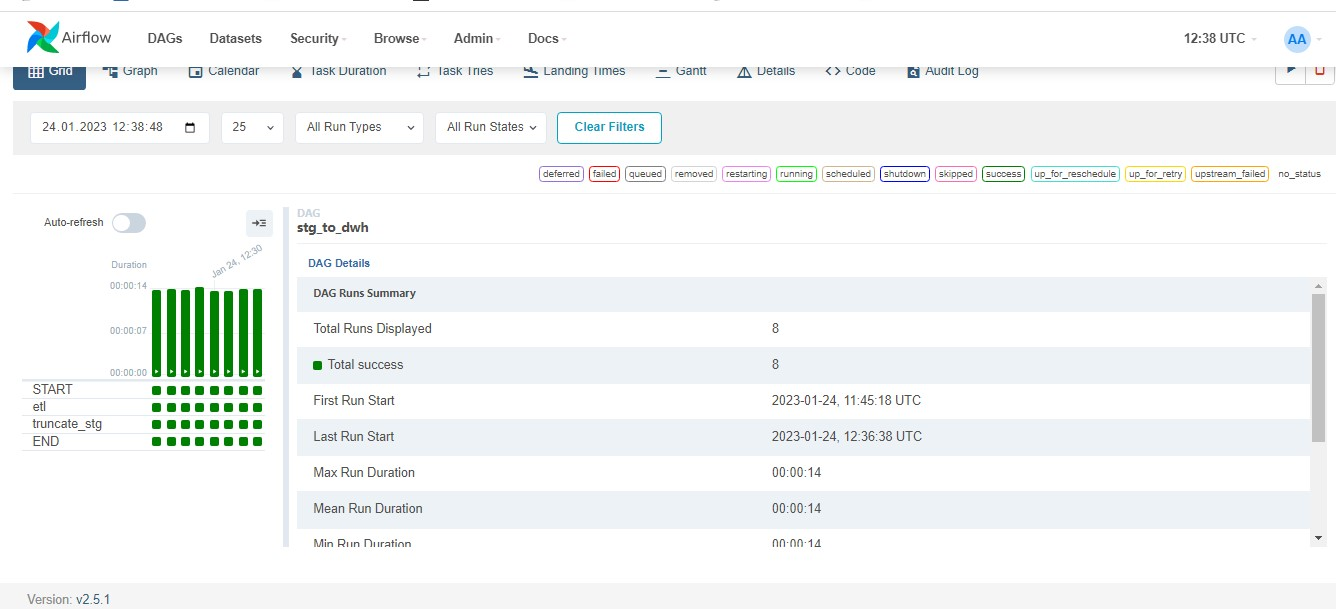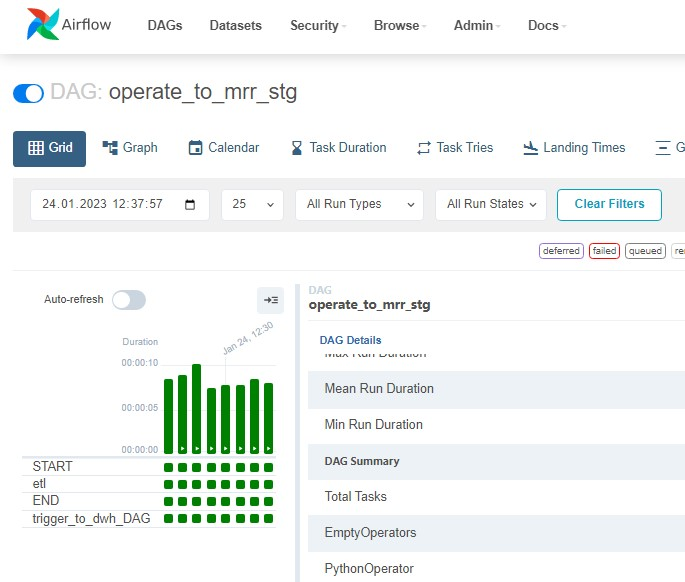

##### Пункт5
Не реализовывал, так как airflow чуть больше,чем полностью состоит из логов. Со временем тасками, ошибками и прочим.

##### Пункт 6

######Процедура 
Для заполнения dwh_dim_date c курсором(там можно все сделать без курсора и ,наверное, без процедуры. Но задание + сам хотел вспомнить.

```
--procedure with cursor
create or replace procedure generate_date(start_date date, end_date date) as $$
declare
	cur cursor for SELECT 
			to_char(dd, 'yyyymmdd')::int date_key,
			date_trunc('day', dd)::date "date",
			date_part('day', dd)::int "day", 
			date_part('month', dd)::int "month",
			date_part('year', dd)::int "year"
		FROM generate_series
			(start_date::timestamp,
     		end_date::timestamp,
     		'1 day'::interval) dd;
begin
	for rec in cur loop
		insert into dwh_dim_dates values(rec.date_key, rec.date, rec.day, rec.month, rec.year);
		raise notice '%', rec;
	end loop;
	commit;
end;
$$ language plpgsql;
call generate_date('2020-01-01', '2020-02-26');
```

###### Процедура
Где есть try-catch, а точнее exception.

```
--some procedure with catch error
CREATE or replace procedure get_customerid(customer_name text)
AS $$
DECLARE
customer_id int;
BEGIN
    SELECT dwh_dim_customers.id INTO STRICT customer_id
        FROM dwh_dim_customers WHERE dwh_dim_customers.name = customer_name;
    raise info 'customer_id: %', customer_id;
exception 
	when plpgsql_error then
		raise info 'error: %', sqlerrm;
		insert into errors values(current_date, customer_name::text, sqlerrm::text);
END;
$$ LANGUAGE plpgsql;

call get_customerid('hyhy');
call get_customerid('Ivan');
```



###### функция
просто функция

```
--somefunction
CREATE FUNCTION get_customername(in x int, out y text)
as $$
	begin
		select "name" from dwh_dim_customers where id = x
		into y;
	end;
$$ LANGUAGE plpgsql;

select * from get_customername(5);
```



##### Пункт 7
Сделал в Power Bi (в первый раз с ним работаю). Простой dashboard. В общее хранилище не заливал.
*   [pdf](https://drive.google.com/file/d/1TD0ZqZvEEEe7Bl9NeJj3Nv4yhu8OV5WT/view?usp=share_link)
*   [pbit](https://drive.google.com/file/d/1g0GNHZGLBfmw4ClTCkDVkqzljzbCZApL/view?usp=share_link)

##### Пункт 8
В моем кейсе , резервное копирование делается через pg_dump на контейнере. Дампы db сохраняются на инстансе.

*   пишем bash script (как безопасно передать пароль в контейнеры не знаю)
*   пишем запуск в cron
*   делал по образцу этой статьи [habr](https://habr.com/ru/post/595641/)



bash script
```
# ~/pg_backup.sh
db_user=postgres
db_host=localhost
db_port=5400

# Days to store backup
keep_day=10

for db_name in mrr stg dwh
do
    backupfolder=~/postgresql/backups/$db_name

    sqlfile=$backupfolder/database-$(date +%d-%m-%Y_%H-%M-%S).sql
    zipfile=$backupfolder/database-$(date +%d-%m-%Y_%H-%M-%S).zip
    mkdir -p $backupfolder

    if docker exec -e PGPASSWORD=postgres dwh pg_dump -U $db_user -h $db_host $db_name > $sqlfile ; then
        echo 'Sql dump created'
    else
        echo 'pg_dump return non-zero code'
    fi

    if gzip -c $sqlfile > $zipfile; then
        echo 'The backup was successfully compressed'
    else
        echo 'Error compressing backup'
    fi

    rm $sqlfile

    # remove old backups
    find $backupfolder -mtime +$keep_day -delete
done 
```



cron
```
0 5 * * 0-6 /home/develtomas/pg_backup.bash
```
